In [63]:
import xarray as xr
import numpy as np
import os
import sitt
import seaobs.geometry as sgeom
import matplotlib
import matplotlib.pyplot as plt
import cmclimate
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaobs.quality as qc
import seaobs.turbulence as turb
import pandas as pd
import gsw
%matplotlib inline
matplotlib.rcParams['figure.figsize']= (20, 8)
matplotlib.rcParams['xtick.labelsize']= 14
matplotlib.rcParams['ytick.labelsize']= 14
matplotlib.rcParams['axes.labelsize']= 16

In [2]:
input_path = "/data/OBS/SSS/eastern_ecc_segments/"
segments = qc.open_segments_from_netcdf(input_path)

In [3]:
segment_test = segments[10]

In [4]:
def open_sss_transect_from_olvac(filename):
    """
    Open an Sea Surface Salinity transect from the OLVAC dataset, and homogenize the coordinates
    
    Parameters
    ----------
    filename : str
        Name of the file to open
    
    Returns
    -------
    ds : xarray.Dataset
        The ADCP transect under the form of a Dataset
    """
    renamed_var = {'TIME': 'time', 'LON': 'lon', 'LAT': 'lat'}    
    ds = xr.open_dataset(filename, autoclose=True).rename(renamed_var).set_coords(('lon', 'lat'))
    ds['lon'] = (ds['lon'] + 360) % 360
    # Sort by time to avoid strange behaviours
    ds = ds.sortby('time')
    for var in ds.variables:
        try:
            del(ds[var].attrs['coordinates'])
        except(KeyError):
            pass
    return ds

In [5]:
def binning_gradients(data, lon_res=0.05, lat_res=0.05, lon_min=0., lon_max=360., lat_min=-80., lat_max=80, min_nobs=100):
    # Define the latitudinal and longitudinal binning
    #lon_bins = np.arange(data['lon'].min().data, data['lon'].max().data, lon_res)
    lon_bins = np.arange(lon_min, lon_max, lon_res)
    lon_labels = lon_bins[:-1] - np.diff(lon_bins) / 2
    #lat_bins = np.arange(data['lat'].min().data, data['lat'].max().data, lat_res)
    lat_bins = np.arange(lat_min, lat_max, lat_res)
    lat_labels = lat_bins[:-1] - np.diff(lat_bins) / 2
    mean_gradients = []
    total_nobs = []
    lat_values = []
    for i, ds in list(data.groupby_bins('lat', lat_bins, labels=lat_labels, include_lowest=True)):
        try:
            group = ds.groupby_bins('lon', lon_bins, labels=lon_labels, include_lowest=True)
            bins = group.median().sortby('lon_bins')
            nobs = group.count().sortby('lon_bins')
            mean_gradients.append(bins)
            total_nobs.append(nobs)
            lat_values.append(i)
        except (ValueError, StopIteration):
            mean_gradients.append(xr.DataArray(np.full(len(lon_labels), np.nan), dims='lon_bins', 
                                 coords={'lon_bins': ('lon_bins', lon_labels)}))
            lat_values.append(i)
    res_bins = xr.concat(mean_gradients, dim='lat').assign_coords(lat=lat_values).rename({'lon_bins': 'lon'}).sortby('lat')
    res_obs = xr.concat(total_nobs, dim='lat').assign_coords(lat=lat_values).rename({'lon_bins': 'lon'}).sortby('lat')
    return xr.Dataset({data.name:res_bins, 'nobs':res_obs})

In [6]:
def bin_2d_data(data, lon_res=0.05, lat_res=0.05, lon_min=0., lon_max=360., lat_min=-80., lat_max=80, min_nobs=100):
    # Define the latitudinal and longitudinal binning
    lon_bins = np.arange(lon_min, lon_max, lon_res)
    lon_labels = lon_bins[:-1] - np.diff(lon_bins) / 2
    lat_bins = np.arange(lat_min, lat_max, lat_res)
    lat_labels = lat_bins[:-1] - np.diff(lat_bins) / 2    
    new_data = data.groupby_bins('lon', bins=lon_bins, labels=lon_labels).mean('lon')
    new_data = new_data.groupby_bins('lat', bins=lat_bins, labels=lat_labels).mean('lat')
    return new_data.rename({'lon_bins': 'lon', 'lat_bins': 'lat'})

In [7]:
def compute_annual_cycle(ds, freq='1M'):
    time = pd.date_range("2000-01", "2001", freq=freq)
    an_period = pd.Timedelta(1, unit='Y')
    t = 2 * np.pi * xr.DataArray(pd.to_numeric(time) / an_period.value, dims='time', coords={'time': time})
    mean = ds['mean']
    an_cos = ds['an_cos']
    an_sin = ds['an_sin']
    cycle = mean + an_cos * np.cos(t) + an_sin * np.sin(t)
    return cycle

# Compute buoyancy gradients

## Test on one shiptrack

In [8]:
def compute_buoyancy(data):
    p = 0 * data['lon']
    SA = gsw.SA_from_SP(data['SSS'], p, data['lon'], data['lat'])
    rho = gsw.rho_t_exact(SA, data['SST'], p)
    b = 9.81 * (1 - rho / 1025)
    return data.assign(buoyancy=xr.DataArray(rho, dims='time'))

In [9]:
def compute_tracer_gradients(data, max_dl=5e3, min_dl=500):
    data = data.drop(['SST_QC', 'SST_ERROR', 'SSS_QC', 'SSS_ERROR'])
    segment_buoyancy = compute_buoyancy(data)
    dy, dx = sgeom.latlon2dydx(segment_buoyancy['lat'], segment_buoyancy['lon'], dim='time')
    dl = np.sqrt(dx ** 2 + dy ** 2)
    tracer_gradients = segment_buoyancy.diff('time') / dl
    tracer_gradients = tracer_gradients.assign_coords(dl=dl) 
    return tracer_gradients.where((dl <= max_dl) & (dl >= min_dl), drop=True)

In [10]:
data = open_sss_transect_from_olvac('/data/OBS/SSS/sssdata_20171109104510_netcdf_good/sssdata_netcdf_good_3ENY2_20080226_20080316.nc')

In [11]:
tracer_gradients = compute_tracer_gradients(data)

In [12]:
print(tracer_gradients)

<xarray.Dataset>
Dimensions:   (time: 3058)
Coordinates:
  * time      (time) datetime64[ns] 2008-02-26T04:10:00 2008-02-26T04:15:00 ...
    lon       (time) float32 166.425 166.41 166.391 166.379 166.385 166.4 ...
    lat       (time) float32 -22.2587 -22.2507 -22.2412 -22.2547 -22.2732 ...
    dl        (time) float64 856.9 1.81e+03 2.204e+03 1.914e+03 2.153e+03 ...
Data variables:
    SST       (time) float64 -0.0001015 9.391e-06 -1.497e-05 -1.097e-05 ...
    SSS       (time) float64 -3.034e-05 -2.099e-05 -2.313e-05 -1.254e-05 ...
    buoyancy  (time) float64 1.096e-05 -1.888e-05 -1.24e-05 -5.779e-06 ...


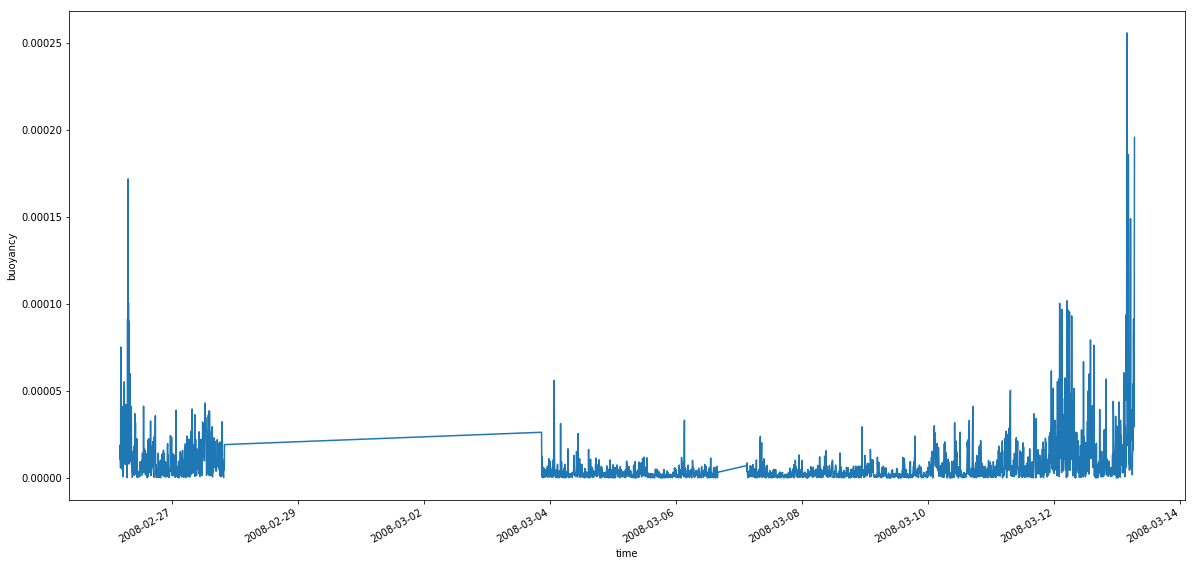

In [13]:
np.abs(tracer_gradients['buoyancy']).plot()

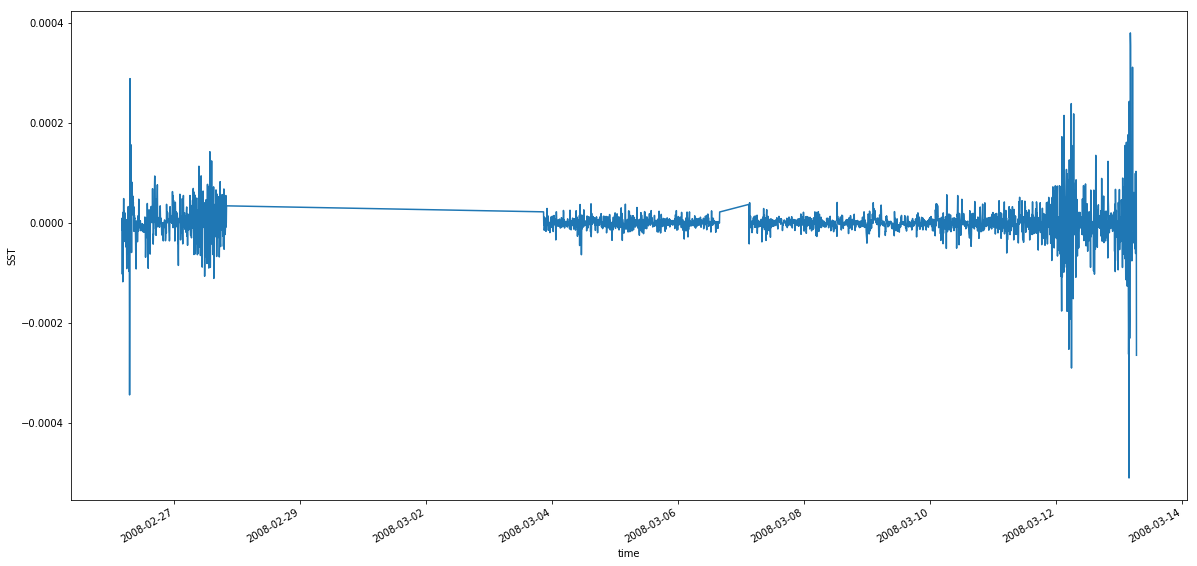

In [14]:
tracer_gradients['SST'].plot()

NameError: name 'clean_tracer_gradients' is not defined

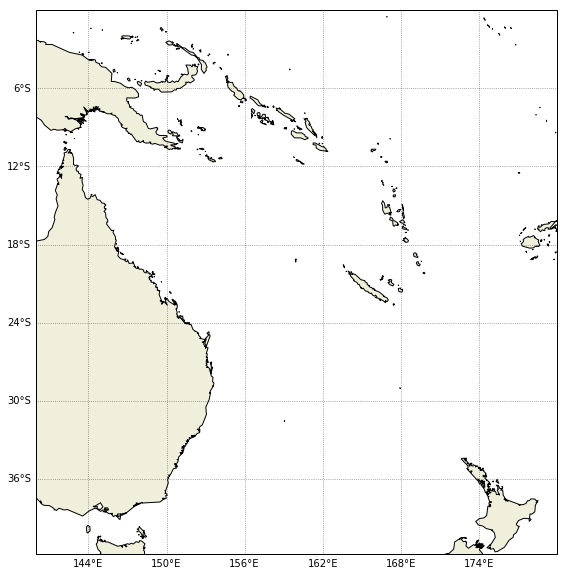

In [15]:
sitt.plot.add_map(lon_min=140, lon_max=180, lat_min=-40, lat_max=0, scale='low')
plt.scatter(clean_tracer_gradients['lon'], clean_tracer_gradients['lat'], c=clean_tracer_gradients['SST'], cmap='seismic')

## All shiptracks 

In [16]:
import os
input_path = "/data/OBS/SSS/sssdata_20171109104510_netcdf_good/"
filenames = sorted(os.listdir(input_path))
missions = [f[20:-3] for  f in filenames]

In [17]:
list_of_tracer_gradients = []
for mission in missions:
    data = open_sss_transect_from_olvac(input_path +"sssdata_netcdf_good_" + mission + '.nc')
    try:
        tracer_gradients = compute_tracer_gradients(data)
        list_of_tracer_gradients.append(tracer_gradients)
    except ValueError:
        pass
all_gradients = xr.concat(list_of_tracer_gradients, dim='time')

## Mean annual buoyancy gradients

In [18]:
buoyancy_gradients = binning_gradients(np.abs(all_gradients['buoyancy']), lon_res=2, lat_res=2)

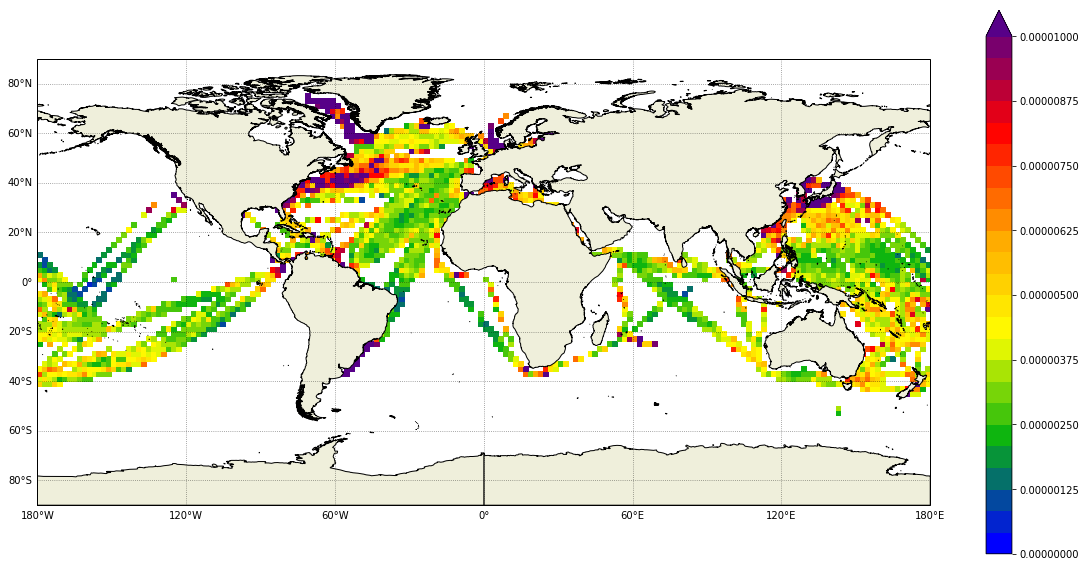

In [19]:
annual_buoyancy_gradients = buoyancy_gradients['buoyancy'].where(buoyancy_gradients['nobs'] > 100)
sitt.plot.add_map(lon_min=-180, lon_max=180, lat_min=-90, lat_max=90, scale='low')
annual_buoyancy_gradients.plot(cmap=cmclimate.cm.BlGrYeOrReVi200, vmin=0, vmax=1e-5, levels=25)

## Mean semi-annual buoyancy gradients

In [20]:
all_gradients_by_season = dict(all_gradients.groupby('time.season'))

In [21]:
buoyancy_gradients_DJF = binning_gradients(np.abs(all_gradients_by_season['DJF']['buoyancy']), lon_res=1, lat_res=1)
nobs_DJF = buoyancy_gradients_DJF['nobs']

In [22]:
buoyancy_gradients_MAM = binning_gradients(np.abs(all_gradients_by_season['MAM']['buoyancy']), lon_res=1, lat_res=1)
nobs_MAM = buoyancy_gradients_MAM['nobs']

In [23]:
buoyancy_gradients_winter = 1. / (nobs_MAM + nobs_DJF) * (nobs_MAM *buoyancy_gradients_MAM +  nobs_DJF * buoyancy_gradients_DJF)
buoyancy_gradients_winter['nobs'] = nobs_MAM + nobs_DJF

In [24]:
buoyancy_gradients_winter

<xarray.Dataset>
Dimensions:   (lat: 124, lon: 359)
Coordinates:
  * lat       (lat) float64 -65.5 -58.5 -57.5 -55.5 -52.5 -51.5 -50.5 -49.5 ...
  * lon       (lon) float64 -0.5 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 ...
Data variables:
    buoyancy  (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    nobs      (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...

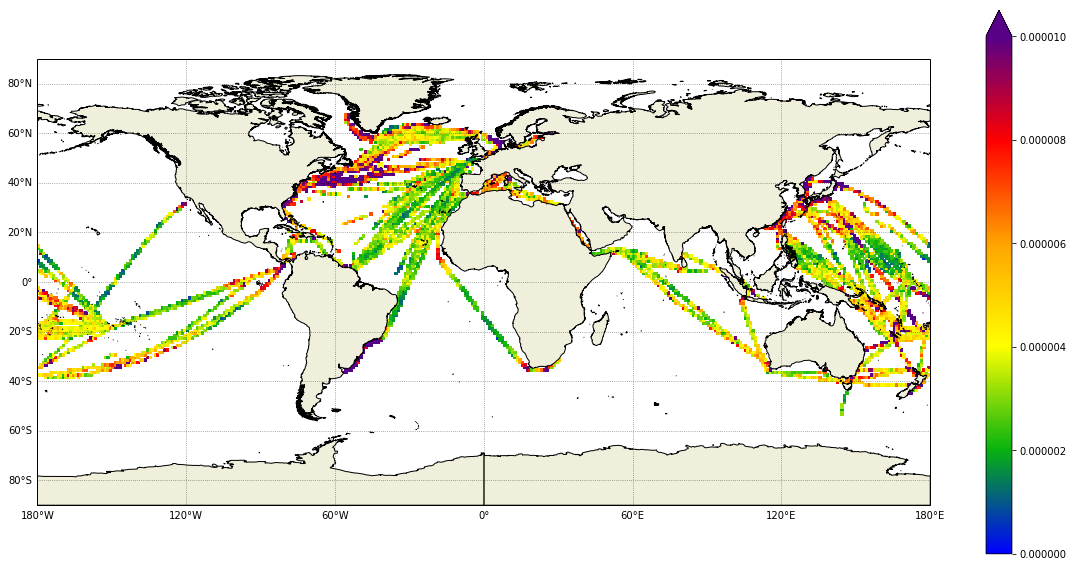

In [25]:
mean_buoyancy_gradients_winter = buoyancy_gradients_winter['buoyancy'].where(buoyancy_gradients_winter['nobs'] > 10)
sitt.plot.add_map(lon_min=-180, lon_max=180, lat_min=-90, lat_max=90, scale='low')
mean_buoyancy_gradients_winter.plot(cmap=cmclimate.cm.BlGrYeOrReVi200, vmin=0, vmax=1e-5)

In [26]:
mean_buoyancy_gradients_winter = buoyancy_gradients_SON['buoyancy'].where(buoyancy_gradients_winter['nobs'] > 100)
sitt.plot.add_map(lon_min=-180, lon_max=180, lat_min=-90, lat_max=90, scale='low')
mean_buoyancy_gradients_winter.plot(cmap=cmclimate.cm.BlGrYeOrReVi200, vmin=0, vmax=1e-5)

NameError: name 'buoyancy_gradients_SON' is not defined

In [ ]:
buoyancy_gradients_DJF = binning_gradients(np.abs(all_gradients_by_season['DJF']['buoyancy']), lon_res=2, lat_res=2)
nobs_DJF = buoyancy_gradients_DJF['nobs']

In [ ]:
buoyancy_gradients_JJA = binning_gradients(np.abs(all_gradients_by_season['JJA']['buoyancy']), lon_res=2, lat_res=2)

In [ ]:
buoyancy_gradients_SON = binning_gradients(np.abs(all_gradients_by_season['SON']['buoyancy']), lon_res=2, lat_res=2)

In [ ]:
sst_gradients = binning_gradients(np.abs(all_gradients['SST']), lon_res=1, lat_res=1)

In [ ]:
sst_gradients

In [ ]:
mean_buoyancy_gradients_winter = sst_gradients['SST'].where(sst_gradients['nobs'] > 100)
sitt.plot.add_map(lon_min=-180, lon_max=180, lat_min=-90, lat_max=90, scale='low')
mean_buoyancy_gradients_winter.plot(cmap=cmclimate.cm.BlGrYeOrReVi200, vmin=0, vmax=5e-5)

In [ ]:
sitt.plot.add_map(lon_min=140, lon_max=180, lat_min=-40, lat_max=0, scale='low')
plt.scatter(all_gradients['lon'], all_gradients['lat'], c=all_gradients['buoyancy'], cmap='seismic', vmin=-1e-5, vmax=1e-5)

In [ ]:
sitt.plot.add_map(lon_min=-180, lon_max=180, lat_min=-90, lat_max=90, scale='low')
buoyancy_gradients_DJF['buoyancy'].where(buoyancy_gradients_DJF['nobs'] > 100).plot(cmap=cmclimate.cm.BlGrYeOrReVi200, vmin=0, vmax=1e-5, levels=25)

In [ ]:
buoyancy_gradients_JJA

# Available potential energy density

### Load Mixed-Layer climatology from CARS

In [27]:
cars_mld = xr.open_dataset("/data/CLIMATOLOGY/CARS/mld_cars2009a.nc")
annual_mld_cycle = compute_annual_cycle(cars_mld)

In [28]:
mld_by_season = annual_mld_cycle.groupby('time.season').mean('time')

In [29]:
buoyancy_gradients = binning_gradients(np.abs(all_gradients['buoyancy']), lon_res=2, lat_res=2)

In [30]:
mean_MDL = cars_mld['mean']
mean_MDL

<xarray.DataArray 'mean' (lat: 331, lon: 721)>
[238651 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5.5 ...
  * lat      (lat) float32 -75.0 -74.5 -74.0 -73.5 -73.0 -72.5 -72.0 -71.5 ...
Attributes:
    long_name:  mean mixed layer depth
    units:      meters
    ipositive:  -1
    positive:   down

In [31]:
mean_MLD_2deg = bin_2d_data(mean_MDL, lon_res=2, lat_res=2)

In [32]:
APE = buoyancy_gradients['buoyancy'] *  mean_MLD_2deg ** 2

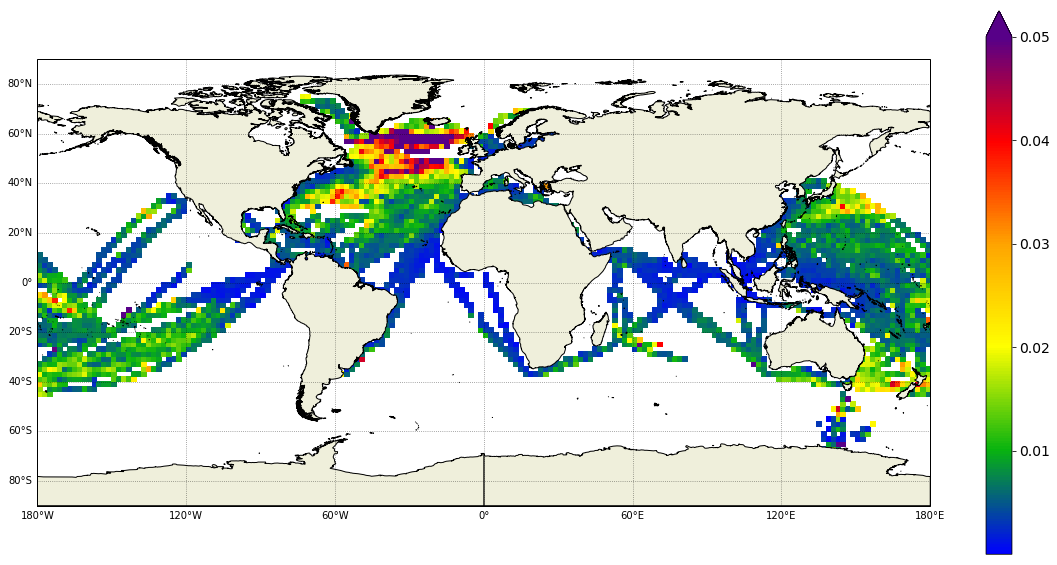

In [55]:
sitt.plot.add_map(lon_min=-180, lon_max=180, lat_min=-90, lat_max=90, scale='low')
APE.plot(vmax=0.05, cmap=cmclimate.cm.BlGrYeOrReVi200)

## Winter

In [34]:
buoyancy_gradients_DJF = binning_gradients(np.abs(all_gradients_by_season['DJF']['buoyancy']), lon_res=2, lat_res=2)
nobs_DJF = buoyancy_gradients_DJF['nobs']

In [35]:
APE_DJF = mld_by_season.sel(season='DJF') ** 2 * buoyancy_gradients_DJF['buoyancy']

/home/serazin/anaconda2/envs/oceanscience/lib/python3.5/site-packages/matplotlib/colors.py:1020: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


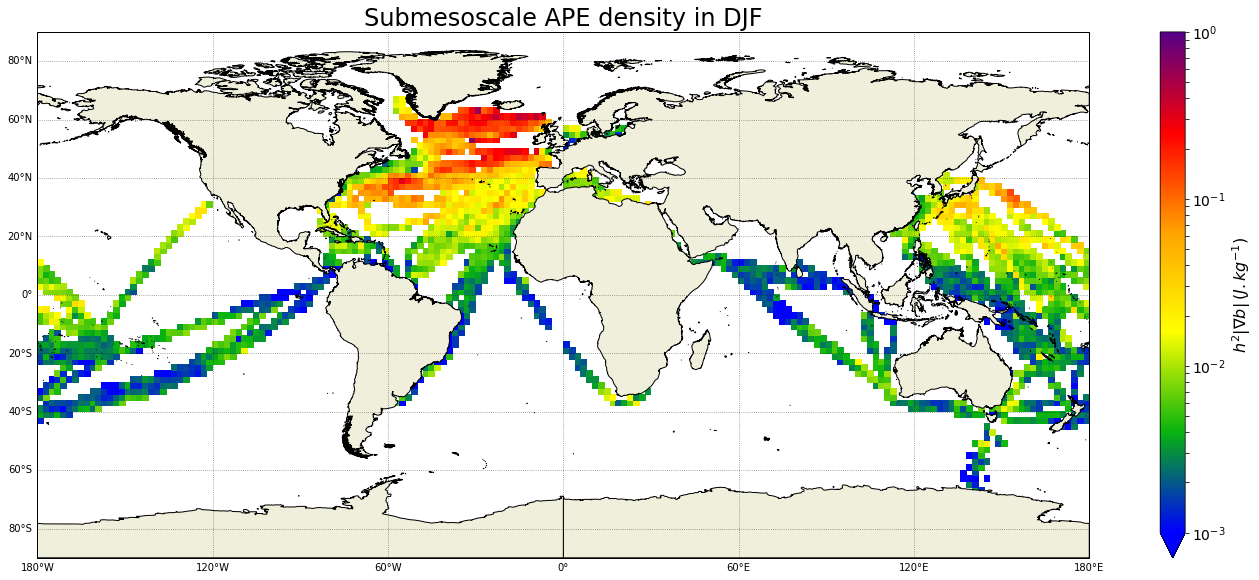

In [66]:
from matplotlib.colors import LogNorm
sitt.plot.add_map(lon_min=-180, lon_max=180, lat_min=-90, lat_max=90, scale='low')
APE_DJF.plot(cmap=cmclimate.cm.BlGrYeOrReVi200, norm=LogNorm(), vmax=1, vmin=1e-3,
             cbar_kwargs={'orientation': 'vertical', 'label': r'$h^2 |\nabla b|\,(J.kg^{-1})$'})
plt.title('Submesoscale APE density in DJF', size=24)
plt.tight_layout()

/home/serazin/anaconda2/envs/oceanscience/lib/python3.5/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


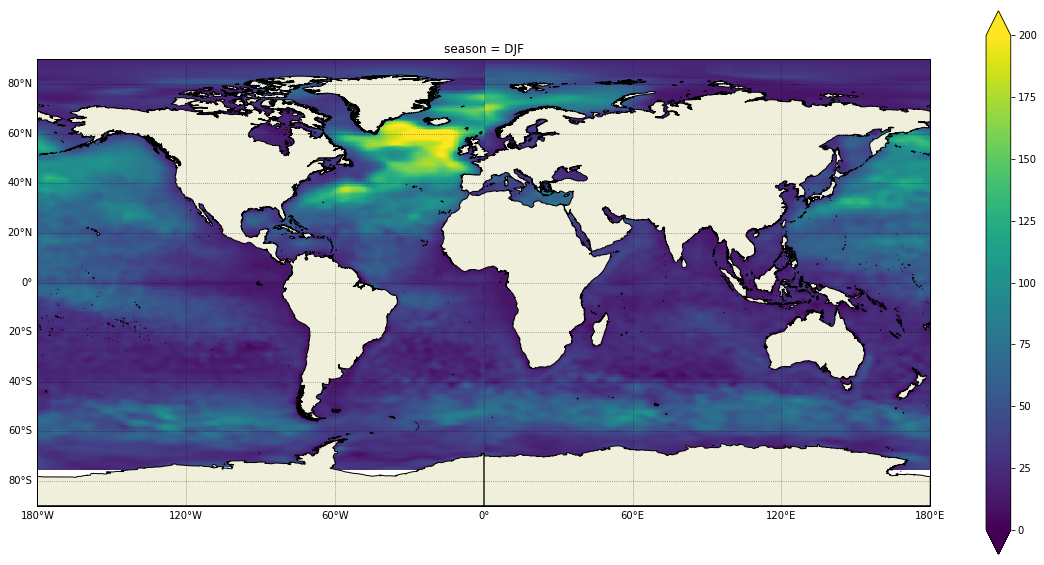

In [37]:
sitt.plot.add_map(lon_min=-180, lon_max=180, lat_min=-90, lat_max=90, scale='low')
mld_by_season.sel(season='DJF').plot(vmin=0, vmax=200)

# Summer

In [58]:
buoyancy_gradients_JJA = binning_gradients(np.abs(all_gradients_by_season['JJA']['buoyancy']), lon_res=2, lat_res=2)
nobs_JJA= buoyancy_gradients_JJA['nobs']

In [59]:
APE_JJA = mld_by_season.sel(season='JJA') ** 2 * buoyancy_gradients_JJA['buoyancy']

/home/serazin/anaconda2/envs/oceanscience/lib/python3.5/site-packages/matplotlib/colors.py:1020: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


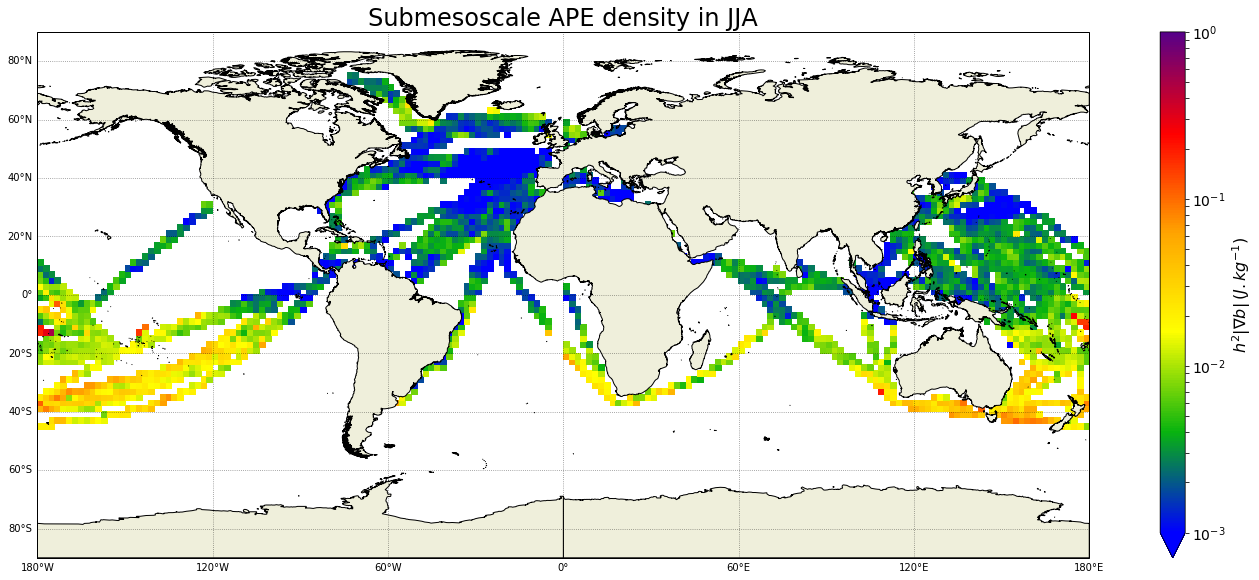

In [67]:
from matplotlib.colors import LogNorm
sitt.plot.add_map(lon_min=-180, lon_max=180, lat_min=-90, lat_max=90, scale='low')
APE_JJA.plot(cmap=cmclimate.cm.BlGrYeOrReVi200, norm=LogNorm(), vmax=1, vmin=1e-3,
             cbar_kwargs={'orientation': 'vertical', 'label': r'$h^2 |\nabla b|\,(J.kg^{-1})$'})
plt.title('Submesoscale APE density in JJA', size=24)
plt.tight_layout()

/home/serazin/anaconda2/envs/oceanscience/lib/python3.5/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


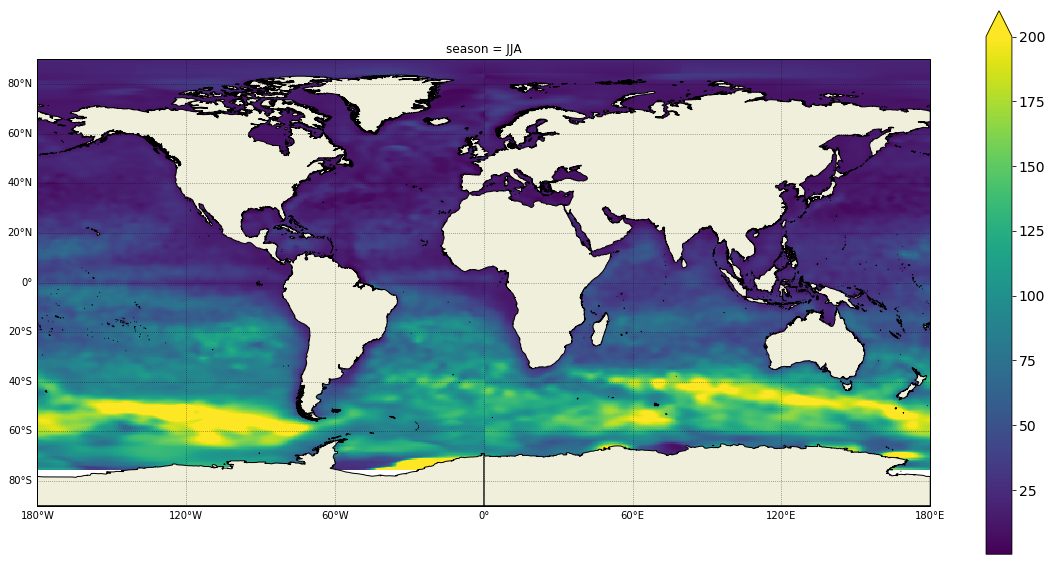

In [61]:
sitt.plot.add_map(lon_min=-180, lon_max=180, lat_min=-90, lat_max=90, scale='low')
mld_by_season.sel(season='JJA').plot(vmax=200)